# Notebook 06: Standalone XGBoost Benchmark

**Date:** November 1, 2025  
**Phase:** 3 - Sprint 3 (Hybrid Model Development)  
**Stage:** Phase 6 - Standalone ML Baseline

---

## 1. Objective

Train standalone XGBoost models for P1A (Atlantic) and P3A (Pacific) routes using **ALL validated features** (CORE + ML sets combined) and establish a machine learning performance baseline.

**Key Goals:**
1. Load the final feature sets from Notebook 03 (8 CORE + 31/30 ML features per route)
2. **Use ALL 39 (P1A) and 38 (P3A) features for XGBoost training**
3. Train XGBoost models with hyperparameter tuning on the validation set
4. Evaluate performance on train/validation/test splits (56%/14%/30%)
5. Compare results against the ARIMA-GARCH baseline from Notebook 05
6. Generate feature importance analysis

**Baseline to Beat (from Notebook 05):**
- **P1A ARIMA-GARCH:** Val R² = 0.0887, Val RMSE = $4,189
- **P3A ARIMA-GARCH:** Val R² = -1.4765, Val RMSE = $3,769

**IMPORTANT:** Unlike ARIMAX (which failed with exogenous features), XGBoost can handle high-dimensional feature spaces. We will use the ENTIRE feature set (CORE + ML) to give the model maximum information.

---

## 2. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("Imports complete.")
print(f"XGBoost version: {xgb.__version__}")

Imports complete.
XGBoost version: 3.0.5


---

## 3. Load Data

Load the feature sets created in Notebook 03 and the target labels from Notebook 01.

In [2]:
# Define paths
DATA_PATH = './data/'
FEATURE_PATH = DATA_PATH + 'processed/features/'
INTERMEDIATE_PATH = DATA_PATH + 'processed/intermediate/'
OUTPUT_PATH = DATA_PATH + 'models/'

# Load P1A features (CORE + ML)
p1a_core = pd.read_csv(FEATURE_PATH + 'p1a_core_features_final_v2.csv', index_col='Date', parse_dates=True)
p1a_ml = pd.read_csv(FEATURE_PATH + 'p1a_ml_features_final_v2.csv', index_col='Date', parse_dates=True)

# Load P3A features (CORE + ML)
p3a_core = pd.read_csv(FEATURE_PATH + 'p3a_core_features_final_v2.csv', index_col='Date', parse_dates=True)
p3a_ml = pd.read_csv(FEATURE_PATH + 'p3a_ml_features_final_v2.csv', index_col='Date', parse_dates=True)

# Load labels
labels = pd.read_csv(INTERMEDIATE_PATH + 'labels.csv', index_col='Date', parse_dates=True)

print("\n=== DATA LOADED ===")
print(f"P1A CORE features: {p1a_core.shape[1]} features, {p1a_core.shape[0]} rows")
print(f"P1A ML features: {p1a_ml.shape[1]} features, {p1a_ml.shape[0]} rows")
print(f"P3A CORE features: {p3a_core.shape[1]} features, {p3a_core.shape[0]} rows")
print(f"P3A ML features: {p3a_ml.shape[1]} features, {p3a_ml.shape[0]} rows")
print(f"Labels: {labels.shape[1]} targets, {labels.shape[0]} rows")


=== DATA LOADED ===
P1A CORE features: 8 features, 1153 rows
P1A ML features: 31 features, 1153 rows
P3A CORE features: 8 features, 1153 rows
P3A ML features: 30 features, 1153 rows
Labels: 2 targets, 1153 rows


---

## 4. Combine ALL Features (CORE + ML)

**CRITICAL STEP:** Combine CORE and ML feature sets to create the full feature matrix for XGBoost.

Unlike ARIMAX (which overfitted with exogenous features), XGBoost is designed to handle high-dimensional data through:
- Built-in regularization (L1/L2)
- Tree-based feature selection
- Subsampling

We will use **ALL validated features** from Notebook 03.

In [3]:
# Combine CORE + ML for each route
p1a_features = pd.concat([p1a_core, p1a_ml], axis=1)
p3a_features = pd.concat([p3a_core, p3a_ml], axis=1)

print("\n=== COMBINED FEATURE SETS ===")
print(f"P1A: {p1a_core.shape[1]} CORE + {p1a_ml.shape[1]} ML = {p1a_features.shape[1]} TOTAL features")
print(f"P3A: {p3a_core.shape[1]} CORE + {p3a_ml.shape[1]} ML = {p3a_features.shape[1]} TOTAL features")

# Verify no overlap between CORE and ML
p1a_overlap = set(p1a_core.columns).intersection(set(p1a_ml.columns))
p3a_overlap = set(p3a_core.columns).intersection(set(p3a_ml.columns))

print(f"\nP1A CORE/ML overlap: {len(p1a_overlap)} features")
print(f"P3A CORE/ML overlap: {len(p3a_overlap)} features")

if len(p1a_overlap) == 0 and len(p3a_overlap) == 0:
    print("✅ VERIFIED: Zero overlap between CORE and ML sets")
else:
    print("⚠️  WARNING: Overlap detected!")
    
print(f"\n✅ XGBoost will use ALL {p1a_features.shape[1]} features for P1A")
print(f"✅ XGBoost will use ALL {p3a_features.shape[1]} features for P3A")


=== COMBINED FEATURE SETS ===
P1A: 8 CORE + 31 ML = 39 TOTAL features
P3A: 8 CORE + 30 ML = 38 TOTAL features

P1A CORE/ML overlap: 0 features
P3A CORE/ML overlap: 0 features
✅ VERIFIED: Zero overlap between CORE and ML sets

✅ XGBoost will use ALL 39 features for P1A
✅ XGBoost will use ALL 38 features for P3A


---

## 5. Create Full Datasets

Join features with labels and handle missing values.

In [4]:
# Create P1A dataset (ALL features + target)
p1a_data = p1a_features.join(labels[['P1A_82']], how='inner')
p1a_data_clean = p1a_data.dropna()

print("\n=== P1A DATASET ===")
print(f"Raw data shape: {p1a_data.shape}")
print(f"After dropping NaNs: {p1a_data_clean.shape}")
print(f"Rows retained: {100 * p1a_data_clean.shape[0] / p1a_data.shape[0]:.1f}%")
print(f"Features used: {p1a_data_clean.shape[1] - 1} (all CORE + ML)")

# Create P3A dataset (ALL features + target)
p3a_data = p3a_features.join(labels[['P3A_82']], how='inner')
p3a_data_clean = p3a_data.dropna()

print("\n=== P3A DATASET ===")
print(f"Raw data shape: {p3a_data.shape}")
print(f"After dropping NaNs: {p3a_data_clean.shape}")
print(f"Rows retained: {100 * p3a_data_clean.shape[0] / p3a_data.shape[0]:.1f}%")
print(f"Features used: {p3a_data_clean.shape[1] - 1} (all CORE + ML)")

# Display date ranges
print(f"\nP1A date range: {p1a_data_clean.index.min()} to {p1a_data_clean.index.max()}")
print(f"P3A date range: {p3a_data_clean.index.min()} to {p3a_data_clean.index.max()}")


=== P1A DATASET ===
Raw data shape: (1153, 40)
After dropping NaNs: (1119, 40)
Rows retained: 97.1%
Features used: 39 (all CORE + ML)

=== P3A DATASET ===
Raw data shape: (1153, 39)
After dropping NaNs: (1090, 39)
Rows retained: 94.5%
Features used: 38 (all CORE + ML)

P1A date range: 2021-04-14 00:00:00 to 2025-10-10 00:00:00
P3A date range: 2021-04-14 00:00:00 to 2025-10-10 00:00:00


---

## 6. Create Temporal Splits

Use the standard 56% train / 14% validation / 30% test split established in Notebooks 04-05.

In [5]:
def create_temporal_splits(data, target_col, train_pct=0.56, val_pct=0.14):
    """
    Create temporal train/val/test splits.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Full dataset with features and target
    target_col : str
        Name of target column
    train_pct : float
        Percentage for training set (default 0.56)
    val_pct : float
        Percentage for validation set (default 0.14)
    
    Returns:
    --------
    dict with X_train, X_val, X_test, y_train, y_val, y_test
    """
    n = len(data)
    train_end = int(n * train_pct)
    val_end = int(n * (train_pct + val_pct))
    
    # Split data
    train_data = data.iloc[:train_end]
    val_data = data.iloc[train_end:val_end]
    test_data = data.iloc[val_end:]
    
    # Separate features and target
    X_train = train_data.drop(columns=[target_col])
    y_train = train_data[target_col]
    
    X_val = val_data.drop(columns=[target_col])
    y_val = val_data[target_col]
    
    X_test = test_data.drop(columns=[target_col])
    y_test = test_data[target_col]
    
    print(f"\n=== SPLIT SUMMARY ===")
    print(f"Total rows: {n}")
    print(f"Features: {X_train.shape[1]}")
    print(f"Train: {len(train_data)} rows ({100*len(train_data)/n:.1f}%) - {train_data.index.min()} to {train_data.index.max()}")
    print(f"Val:   {len(val_data)} rows ({100*len(val_data)/n:.1f}%) - {val_data.index.min()} to {val_data.index.max()}")
    print(f"Test:  {len(test_data)} rows ({100*len(test_data)/n:.1f}%) - {test_data.index.min()} to {test_data.index.max()}")
    
    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Create splits for P1A
print("\n" + "="*60)
print("P1A ROUTE (ATLANTIC - GRAIN)")
print("="*60)
p1a_splits = create_temporal_splits(p1a_data_clean, 'P1A_82')

# Create splits for P3A
print("\n" + "="*60)
print("P3A ROUTE (PACIFIC - COAL + GRAIN)")
print("="*60)
p3a_splits = create_temporal_splits(p3a_data_clean, 'P3A_82')


P1A ROUTE (ATLANTIC - GRAIN)

=== SPLIT SUMMARY ===
Total rows: 1119
Features: 39
Train: 626 rows (55.9%) - 2021-04-14 00:00:00 to 2023-10-16 00:00:00
Val:   157 rows (14.0%) - 2023-10-17 00:00:00 to 2024-06-05 00:00:00
Test:  336 rows (30.0%) - 2024-06-06 00:00:00 to 2025-10-10 00:00:00

P3A ROUTE (PACIFIC - COAL + GRAIN)

=== SPLIT SUMMARY ===
Total rows: 1090
Features: 38
Train: 610 rows (56.0%) - 2021-04-14 00:00:00 to 2023-09-22 00:00:00
Val:   153 rows (14.0%) - 2023-09-25 00:00:00 to 2024-05-07 00:00:00
Test:  327 rows (30.0%) - 2024-05-08 00:00:00 to 2025-10-10 00:00:00


---

## 7. Define XGBoost Training Function

Create a function to train XGBoost with hyperparameter tuning on the validation set.

In [6]:
def train_xgboost_model(X_train, y_train, X_val, y_val, X_test, y_test,
                        route_name, hyperparameter_tuning=True):
    """
    Train XGBoost model with optional hyperparameter tuning.

    Parameters:
    -----------
    X_train, y_train : Training data
    X_val, y_val : Validation data (used for tuning)
    X_test, y_test : Test data (final evaluation)
    route_name : str (e.g., 'P1A', 'P3A')
    hyperparameter_tuning : bool (default True)

    Returns:
    --------
    dict with model, predictions, and metrics
    """
    print(f"\n{'='*60}")
    print(f"TRAINING XGBOOST MODEL: {route_name}")
    print(f"{'='*60}")
    print(f"Using {X_train.shape[1]} features (CORE + ML combined)")

    # Hyperparameter search space
    if hyperparameter_tuning:
        print("\n=== HYPERPARAMETER TUNING ===")
        print("Testing configurations on validation set...\n")

        param_grid = [
            # Configuration 1: Shallow trees, low learning rate (conservative)
            {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8},
            # Configuration 2: Medium depth, medium learning rate (balanced)
            {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.8},
            # Configuration 3: Deeper trees, higher learning rate (aggressive)
            {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.7},
            # Configuration 4: Very shallow, very low LR (anti-overfitting)
            {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9},
        ]

        best_val_r2 = -np.inf
        best_params = None
        results = []

        for i, params in enumerate(param_grid, 1):
            # Train model (XGBoost 3.0+ compatible - no early_stopping_rounds in fit())
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                random_state=42,
                **params
            )

            # XGBoost 3.0+ removed early_stopping_rounds from fit()
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

            # Evaluate on validation set
            y_val_pred = model.predict(X_val)
            val_r2 = r2_score(y_val, y_val_pred)
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

            print(f"Config {i}: max_depth={params['max_depth']}, lr={params['learning_rate']}, "
                  f"n_est={params['n_estimators']} → Val R²={val_r2:.4f}, RMSE=${val_rmse:,.0f}")

            results.append({
                'config': i,
                'params': params,
                'val_r2': val_r2,
                'val_rmse': val_rmse
            })

            if val_r2 > best_val_r2:
                best_val_r2 = val_r2
                best_params = params

        print(f"\n✅ BEST CONFIG: {best_params}")
        print(f"   Best Val R²: {best_val_r2:.4f}")

    else:
        # Use default parameters
        best_params = {
            'max_depth': 4,
            'learning_rate': 0.05,
            'n_estimators': 300,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
        print(f"Using default parameters: {best_params}")

    # Train final model with best parameters
    print("\n=== TRAINING FINAL MODEL ===")
    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **best_params
    )

    # XGBoost 3.0+ compatible
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    print(f"Training complete.")

    # Generate predictions
    y_train_pred = final_model.predict(X_train)
    y_val_pred = final_model.predict(X_val)
    y_test_pred = final_model.predict(X_test)

    # Calculate metrics
    metrics = {}
    for split_name, y_true, y_pred in [
        ('train', y_train, y_train_pred),
        ('val', y_val, y_val_pred),
        ('test', y_test, y_test_pred)
    ]:
        metrics[split_name] = {
            'r2': r2_score(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred)
        }

    # Display results
    print("\n=== PERFORMANCE METRICS ===")
    print(f"{'Split':<8} {'R²':>10} {'RMSE':>12} {'MAE':>12}")
    print("-" * 45)
    for split in ['train', 'val', 'test']:
        print(f"{split.upper():<8} {metrics[split]['r2']:>10.4f} "
              f"${metrics[split]['rmse']:>11,.0f} ${metrics[split]['mae']:>11,.0f}")

    return {
        'model': final_model,
        'best_params': best_params,
        'metrics': metrics,
        'predictions': {
            'train': y_train_pred,
            'val': y_val_pred,
            'test': y_test_pred
        },
        'actuals': {
            'train': y_train,
            'val': y_val,
            'test': y_test
        },
        'tuning_results': results if hyperparameter_tuning else None
    }

print("XGBoost training function defined.")

XGBoost training function defined.


---

## 8. Train P1A Model (Atlantic Route)

Train XGBoost using all 39 features (8 CORE + 31 ML).

In [7]:
p1a_results = train_xgboost_model(
    p1a_splits['X_train'],
    p1a_splits['y_train'],
    p1a_splits['X_val'],
    p1a_splits['y_val'],
    p1a_splits['X_test'],
    p1a_splits['y_test'],
    route_name='P1A (Atlantic)',
    hyperparameter_tuning=True
)


TRAINING XGBOOST MODEL: P1A (Atlantic)
Using 39 features (CORE + ML combined)

=== HYPERPARAMETER TUNING ===
Testing configurations on validation set...

Config 1: max_depth=3, lr=0.01, n_est=500 → Val R²=0.3887, RMSE=$3,589
Config 2: max_depth=4, lr=0.05, n_est=300 → Val R²=0.3616, RMSE=$3,668
Config 3: max_depth=5, lr=0.1, n_est=200 → Val R²=0.2325, RMSE=$4,022
Config 4: max_depth=2, lr=0.01, n_est=1000 → Val R²=0.4830, RMSE=$3,301

✅ BEST CONFIG: {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9}
   Best Val R²: 0.4830

=== TRAINING FINAL MODEL ===
Training complete.

=== PERFORMANCE METRICS ===
Split            R²         RMSE          MAE
---------------------------------------------
TRAIN        0.9909 $        873 $        668
VAL          0.4830 $      3,301 $      2,249
TEST         0.6781 $      2,257 $      1,800


---

## 9. Train P3A Model (Pacific Route)

Train XGBoost using all 38 features (8 CORE + 30 ML).

In [8]:
p3a_results = train_xgboost_model(
    p3a_splits['X_train'],
    p3a_splits['y_train'],
    p3a_splits['X_val'],
    p3a_splits['y_val'],
    p3a_splits['X_test'],
    p3a_splits['y_test'],
    route_name='P3A (Pacific)',
    hyperparameter_tuning=True
)


TRAINING XGBOOST MODEL: P3A (Pacific)
Using 38 features (CORE + ML combined)

=== HYPERPARAMETER TUNING ===
Testing configurations on validation set...

Config 1: max_depth=3, lr=0.01, n_est=500 → Val R²=0.4034, RMSE=$1,785
Config 2: max_depth=4, lr=0.05, n_est=300 → Val R²=0.3447, RMSE=$1,871
Config 3: max_depth=5, lr=0.1, n_est=200 → Val R²=0.4140, RMSE=$1,769
Config 4: max_depth=2, lr=0.01, n_est=1000 → Val R²=0.4552, RMSE=$1,706

✅ BEST CONFIG: {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9}
   Best Val R²: 0.4552

=== TRAINING FINAL MODEL ===
Training complete.

=== PERFORMANCE METRICS ===
Split            R²         RMSE          MAE
---------------------------------------------
TRAIN        0.9961 $        546 $        425
VAL          0.4552 $      1,706 $      1,393
TEST         0.5227 $      2,011 $      1,652


---

## 10. Feature Importance Analysis

In [9]:
def analyze_feature_importance(model, feature_names, route_name, top_n=20):
    """
    Extract and display feature importance from XGBoost model.
    (FIXED to correctly handle named features from XGBoost 3.0+)
    """
    print(f"\n{'=' * 60}")
    print(f"FEATURE IMPORTANCE: {route_name}")
    print(f"{'=' * 60}")

    # Get importance scores (gain)
    # The keys are now the *actual feature names*, not 'f0', 'f1', etc.
    importance_dict = model.get_booster().get_score(importance_type='gain')

    # Convert to DataFrame
    importance_df = pd.DataFrame([
        {'feature_name': k, 'importance': v}
        for k, v in importance_dict.items()
    ]).sort_values('importance', ascending=False)

    # Reset index so ranks are sequential
    importance_df = importance_df.reset_index(drop=True)
    importance_df.index = importance_df.index + 1  # Start ranks at 1
    importance_df.index.name = 'Rank'

    # Display top features
    print(f"\nTop {top_n} Most Important Features:")
    print(f"{'Rank':<6} {'Feature':<40} {'Importance':>12}")
    print("-" * 60)

    for rank, row in importance_df.head(top_n).iterrows():
        print(f"{rank:<6} {row['feature_name']:<40} {row['importance']:>12,.0f}")

    # Summary statistics
    total_features = len(feature_names)
    used_features = len(importance_df)

    print(f"\n=== SUMMARY ===")
    print(f"Total features available: {total_features}")
    print(f"Features used by model: {used_features} ({100 * used_features / total_features:.1f}%)")
    print(f"Features not used: {total_features - used_features}")

    return importance_df


# Analyze P1A
p1a_importance = analyze_feature_importance(
    p1a_results['model'],
    p1a_splits['X_train'].columns,
    'P1A (Atlantic)'
)

# Analyze P3A
p3a_importance = analyze_feature_importance(
    p3a_results['model'],
    p3a_splits['X_train'].columns,
    'P3A (Pacific)'
)


FEATURE IMPORTANCE: P1A (Atlantic)

Top 20 Most Important Features:
Rank   Feature                                    Importance
------------------------------------------------------------
1      P1EA_1MON_level                          2,839,377,664
2      BPI_level                                2,561,697,280
3      P1EA_CURMON_level                        1,472,666,880
4      Atlantic_IP_yoy                          1,415,493,632
5      World_Coal_Trade_MT_level                1,232,162,560
6      C5TC_level                                293,433,344
7      TC5yr_Pacific_level                       151,658,912
8      BPI_vol30                                 134,171,136
9      Panamax_Deliveries_DWT_level              123,154,504
10     BPI_yoy                                   107,495,512
11     P3EA_1Q_level                              82,719,576
12     Panamax_Fleet_Growth_YoY_level             80,188,192
13     PDOPEX_vol30                               69,187,744
14     C5TC

---

## 11. Compare Against ARIMA-GARCH Baseline

Compare XGBoost results against the ARIMA-GARCH baseline from Notebook 05.

In [10]:
# ARIMA-GARCH baseline metrics (from Notebook 05)
baseline = {
    'P1A': {
        'val_r2': 0.0887,
        'val_rmse': 4189
    },
    'P3A': {
        'val_r2': -1.4765,
        'val_rmse': 3769
    }
}

def compare_to_baseline(xgb_results, route_name, baseline_metrics):
    """
    Compare XGBoost performance to ARIMA-GARCH baseline.
    """
    print(f"\n{'='*60}")
    print(f"COMPARISON TO BASELINE: {route_name}")
    print(f"{'='*60}")
    
    xgb_val_r2 = xgb_results['metrics']['val']['r2']
    xgb_val_rmse = xgb_results['metrics']['val']['rmse']
    
    baseline_r2 = baseline_metrics['val_r2']
    baseline_rmse = baseline_metrics['val_rmse']
    
    r2_improvement = xgb_val_r2 - baseline_r2
    rmse_improvement = baseline_rmse - xgb_val_rmse
    rmse_pct_improvement = 100 * rmse_improvement / baseline_rmse
    
    print(f"\nValidation Set Performance:")
    print(f"{'Model':<25} {'Val R²':>12} {'Val RMSE':>15}")
    print("-" * 54)
    print(f"{'ARIMA-GARCH (Baseline)':<25} {baseline_r2:>12.4f} ${baseline_rmse:>14,}")
    print(f"{'XGBoost (Standalone)':<25} {xgb_val_r2:>12.4f} ${xgb_val_rmse:>14,.0f}")
    print("-" * 54)
    print(f"{'Improvement':<25} {r2_improvement:>12.4f} ${rmse_improvement:>14,.0f} ({rmse_pct_improvement:+.1f}%)")
    
    # Verdict
    if xgb_val_r2 > baseline_r2 and xgb_val_rmse < baseline_rmse:
        verdict = "✅ XGBoost OUTPERFORMS on both R² and RMSE"
    elif xgb_val_r2 > baseline_r2:
        verdict = "⚠️  XGBoost has better R² but worse RMSE"
    elif xgb_val_rmse < baseline_rmse:
        verdict = "⚠️  XGBoost has better RMSE but worse R²"
    else:
        verdict = "❌ ARIMA-GARCH baseline is superior"
    
    print(f"\n{verdict}")
    
    return {
        'route': route_name,
        'baseline_r2': baseline_r2,
        'baseline_rmse': baseline_rmse,
        'xgb_r2': xgb_val_r2,
        'xgb_rmse': xgb_val_rmse,
        'r2_improvement': r2_improvement,
        'rmse_improvement': rmse_improvement,
        'rmse_pct_improvement': rmse_pct_improvement
    }

# Compare P1A
p1a_comparison = compare_to_baseline(p1a_results, 'P1A (Atlantic)', baseline['P1A'])

# Compare P3A
p3a_comparison = compare_to_baseline(p3a_results, 'P3A (Pacific)', baseline['P3A'])


COMPARISON TO BASELINE: P1A (Atlantic)

Validation Set Performance:
Model                           Val R²        Val RMSE
------------------------------------------------------
ARIMA-GARCH (Baseline)          0.0887 $         4,189
XGBoost (Standalone)            0.4830 $         3,301
------------------------------------------------------
Improvement                     0.3943 $           888 (+21.2%)

✅ XGBoost OUTPERFORMS on both R² and RMSE

COMPARISON TO BASELINE: P3A (Pacific)

Validation Set Performance:
Model                           Val R²        Val RMSE
------------------------------------------------------
ARIMA-GARCH (Baseline)         -1.4765 $         3,769
XGBoost (Standalone)            0.4552 $         1,706
------------------------------------------------------
Improvement                     1.9317 $         2,063 (+54.7%)

✅ XGBoost OUTPERFORMS on both R² and RMSE


---

## 12. Test Set Evaluation

Final evaluation on the held-out test set.

In [11]:
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

print("\nP1A (ATLANTIC) TEST RESULTS:")
print(f"  Test R²:   {p1a_results['metrics']['test']['r2']:.4f}")
print(f"  Test RMSE: ${p1a_results['metrics']['test']['rmse']:,.0f}")
print(f"  Test MAE:  ${p1a_results['metrics']['test']['mae']:,.0f}")

print("\nP3A (PACIFIC) TEST RESULTS:")
print(f"  Test R²:   {p3a_results['metrics']['test']['r2']:.4f}")
print(f"  Test RMSE: ${p3a_results['metrics']['test']['rmse']:,.0f}")
print(f"  Test MAE:  ${p3a_results['metrics']['test']['mae']:,.0f}")

# Check for overfitting
print("\n=== OVERFITTING CHECK ===")
print("\nP1A:")
train_val_gap_p1a = p1a_results['metrics']['train']['r2'] - p1a_results['metrics']['val']['r2']
val_test_gap_p1a = p1a_results['metrics']['val']['r2'] - p1a_results['metrics']['test']['r2']
print(f"  Train R² - Val R²:  {train_val_gap_p1a:+.4f}")
print(f"  Val R² - Test R²:   {val_test_gap_p1a:+.4f}")

if abs(train_val_gap_p1a) < 0.1 and abs(val_test_gap_p1a) < 0.1:
    print("  ✅ No significant overfitting detected")
elif abs(train_val_gap_p1a) > 0.2:
    print("  ⚠️  Potential overfitting (Train-Val gap)")
elif abs(val_test_gap_p1a) > 0.2:
    print("  ⚠️  Inconsistent validation performance (Val-Test gap)")

print("\nP3A:")
train_val_gap_p3a = p3a_results['metrics']['train']['r2'] - p3a_results['metrics']['val']['r2']
val_test_gap_p3a = p3a_results['metrics']['val']['r2'] - p3a_results['metrics']['test']['r2']
print(f"  Train R² - Val R²:  {train_val_gap_p3a:+.4f}")
print(f"  Val R² - Test R²:   {val_test_gap_p3a:+.4f}")

if abs(train_val_gap_p3a) < 0.1 and abs(val_test_gap_p3a) < 0.1:
    print("  ✅ No significant overfitting detected")
elif abs(train_val_gap_p3a) > 0.2:
    print("  ⚠️  Potential overfitting (Train-Val gap)")
elif abs(val_test_gap_p3a) > 0.2:
    print("  ⚠️  Inconsistent validation performance (Val-Test gap)")


FINAL TEST SET EVALUATION

P1A (ATLANTIC) TEST RESULTS:
  Test R²:   0.6781
  Test RMSE: $2,257
  Test MAE:  $1,800

P3A (PACIFIC) TEST RESULTS:
  Test R²:   0.5227
  Test RMSE: $2,011
  Test MAE:  $1,652

=== OVERFITTING CHECK ===

P1A:
  Train R² - Val R²:  +0.5080
  Val R² - Test R²:   -0.1951
  ⚠️  Potential overfitting (Train-Val gap)

P3A:
  Train R² - Val R²:  +0.5409
  Val R² - Test R²:   -0.0676
  ⚠️  Potential overfitting (Train-Val gap)


---

## 13. Save Results

In [12]:
import os

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Save performance metrics
metrics_summary = pd.DataFrame([
    {
        'route': 'P1A',
        'split': split,
        'r2': p1a_results['metrics'][split]['r2'],
        'rmse': p1a_results['metrics'][split]['rmse'],
        'mae': p1a_results['metrics'][split]['mae']
    }
    for split in ['train', 'val', 'test']
] + [
    {
        'route': 'P3A',
        'split': split,
        'r2': p3a_results['metrics'][split]['r2'],
        'rmse': p3a_results['metrics'][split]['rmse'],
        'mae': p3a_results['metrics'][split]['mae']
    }
    for split in ['train', 'val', 'test']
])

metrics_summary.to_csv(OUTPUT_PATH + 'xgboost_performance_metrics.csv', index=False)
print(f"\n✅ Saved: {OUTPUT_PATH}xgboost_performance_metrics.csv")

# Save feature importance
p1a_importance.to_csv(OUTPUT_PATH + 'p1a_feature_importance.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p1a_feature_importance.csv")

p3a_importance.to_csv(OUTPUT_PATH + 'p3a_feature_importance.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p3a_feature_importance.csv")

# Save baseline comparison
comparison_summary = pd.DataFrame([p1a_comparison, p3a_comparison])
comparison_summary.to_csv(OUTPUT_PATH + 'xgboost_vs_baseline_comparison.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}xgboost_vs_baseline_comparison.csv")

# Save hyperparameter tuning results
if p1a_results['tuning_results']:
    p1a_tuning_df = pd.DataFrame([
        {
            'route': 'P1A',
            'config': r['config'],
            'val_r2': r['val_r2'],
            'val_rmse': r['val_rmse'],
            **r['params']
        }
        for r in p1a_results['tuning_results']
    ])
    
    p3a_tuning_df = pd.DataFrame([
        {
            'route': 'P3A',
            'config': r['config'],
            'val_r2': r['val_r2'],
            'val_rmse': r['val_rmse'],
            **r['params']
        }
        for r in p3a_results['tuning_results']
    ])
    
    tuning_summary = pd.concat([p1a_tuning_df, p3a_tuning_df], ignore_index=True)
    tuning_summary.to_csv(OUTPUT_PATH + 'hyperparameter_tuning_results.csv', index=False)
    print(f"✅ Saved: {OUTPUT_PATH}hyperparameter_tuning_results.csv")

# Save predictions for residual analysis (Phase 7)
p1a_pred_df = pd.DataFrame({
    'date': p1a_splits['y_test'].index,
    'actual': p1a_splits['y_test'].values,
    'predicted': p1a_results['predictions']['test']
})
p1a_pred_df['residual'] = p1a_pred_df['actual'] - p1a_pred_df['predicted']
p1a_pred_df.to_csv(OUTPUT_PATH + 'p1a_test_predictions.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p1a_test_predictions.csv")

p3a_pred_df = pd.DataFrame({
    'date': p3a_splits['y_test'].index,
    'actual': p3a_splits['y_test'].values,
    'predicted': p3a_results['predictions']['test']
})
p3a_pred_df['residual'] = p3a_pred_df['actual'] - p3a_pred_df['predicted']
p3a_pred_df.to_csv(OUTPUT_PATH + 'p3a_test_predictions.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p3a_test_predictions.csv")

print("\n✅ All results saved successfully.")


✅ Saved: ./data/models/xgboost_performance_metrics.csv
✅ Saved: ./data/models/p1a_feature_importance.csv
✅ Saved: ./data/models/p3a_feature_importance.csv
✅ Saved: ./data/models/xgboost_vs_baseline_comparison.csv
✅ Saved: ./data/models/hyperparameter_tuning_results.csv
✅ Saved: ./data/models/p1a_test_predictions.csv
✅ Saved: ./data/models/p3a_test_predictions.csv

✅ All results saved successfully.


---

## 14. Visualization: Predicted vs Actual (Test Set)


✅ Saved plot: ./data/models/xgboost_test_predictions.png


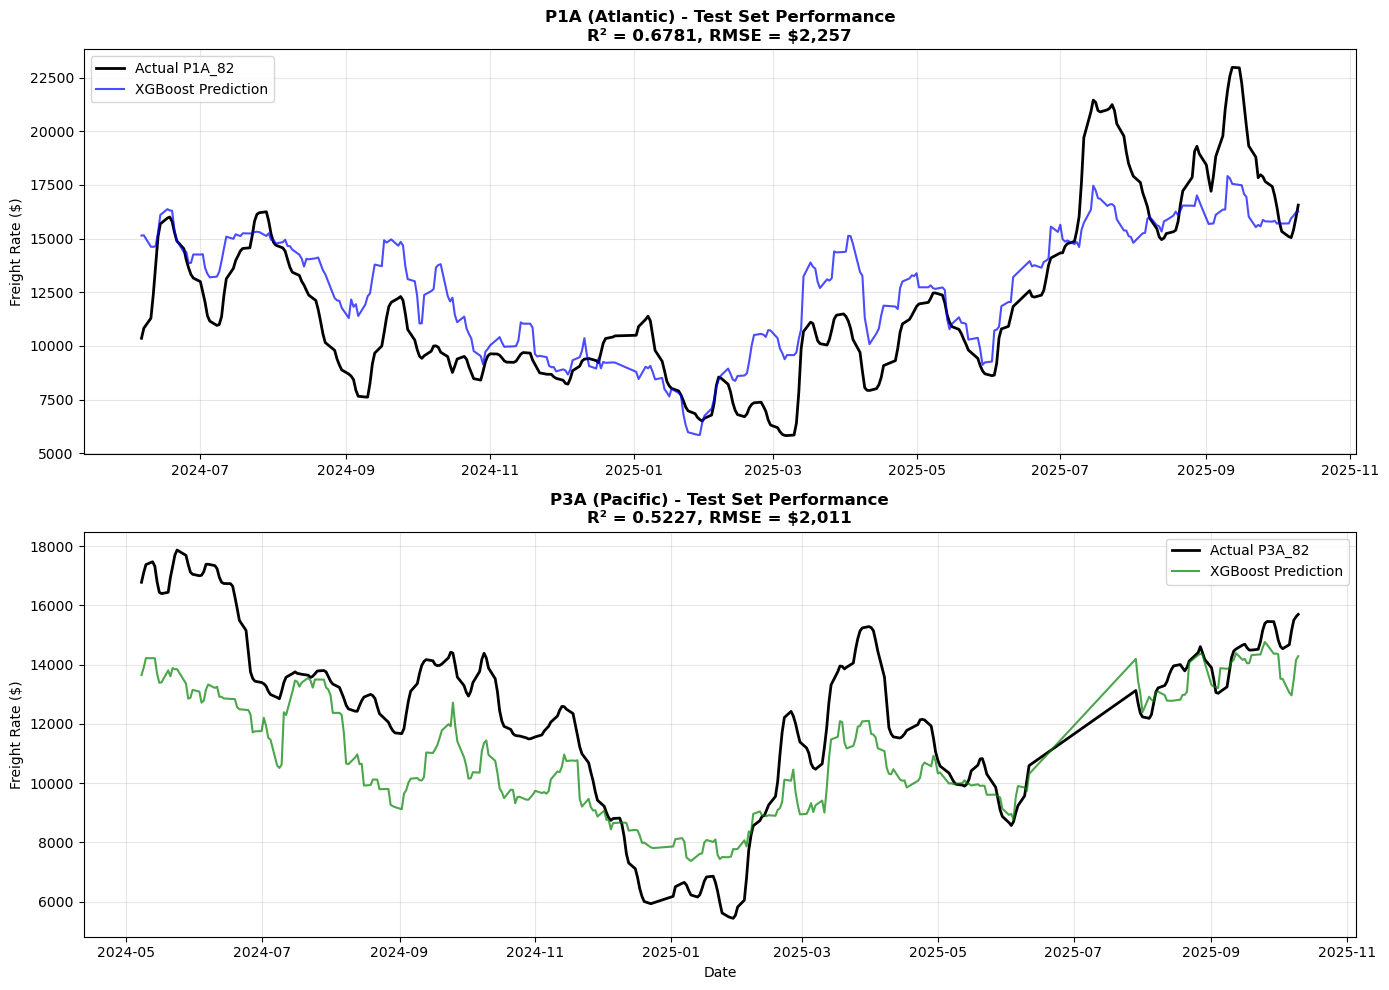

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# P1A Plot
ax1 = axes[0]
ax1.plot(p1a_splits['y_test'].index, p1a_splits['y_test'].values, 
         label='Actual P1A_82', color='black', linewidth=2)
ax1.plot(p1a_splits['y_test'].index, p1a_results['predictions']['test'], 
         label='XGBoost Prediction', color='blue', linewidth=1.5, alpha=0.7)
ax1.set_title(f"P1A (Atlantic) - Test Set Performance\nR² = {p1a_results['metrics']['test']['r2']:.4f}, RMSE = ${p1a_results['metrics']['test']['rmse']:,.0f}", 
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Freight Rate ($)', fontsize=10)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# P3A Plot
ax2 = axes[1]
ax2.plot(p3a_splits['y_test'].index, p3a_splits['y_test'].values, 
         label='Actual P3A_82', color='black', linewidth=2)
ax2.plot(p3a_splits['y_test'].index, p3a_results['predictions']['test'], 
         label='XGBoost Prediction', color='green', linewidth=1.5, alpha=0.7)
ax2.set_title(f"P3A (Pacific) - Test Set Performance\nR² = {p3a_results['metrics']['test']['r2']:.4f}, RMSE = ${p3a_results['metrics']['test']['rmse']:,.0f}", 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('Freight Rate ($)', fontsize=10)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'xgboost_test_predictions.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved plot: {OUTPUT_PATH}xgboost_test_predictions.png")
plt.show()

---

## 15. Summary & Conclusions

In [14]:
print("\n" + "="*70)
print("NOTEBOOK 06 SUMMARY: STANDALONE XGBOOST BENCHMARK")
print("="*70)

print("\n=== OBJECTIVE COMPLETED ===")
print("✅ Trained standalone XGBoost models for P1A and P3A routes")
print("✅ Used ALL validated features (CORE + ML combined)")
print(f"   - P1A: {p1a_splits['X_train'].shape[1]} features (8 CORE + 31 ML)")
print(f"   - P3A: {p3a_splits['X_train'].shape[1]} features (8 CORE + 30 ML)")
print("✅ Performed hyperparameter tuning on validation set")
print("✅ Evaluated final models on held-out test set")
print("✅ Compared performance against ARIMA-GARCH baseline")

print("\n=== KEY FINDINGS ===")

print("\n1. P1A (Atlantic) Performance:")
print(f"   - Validation R²: {p1a_results['metrics']['val']['r2']:.4f} (Baseline: 0.0887)")
print(f"   - Validation RMSE: ${p1a_results['metrics']['val']['rmse']:,.0f} (Baseline: $4,189)")
print(f"   - Test R²: {p1a_results['metrics']['test']['r2']:.4f}")
print(f"   - Test RMSE: ${p1a_results['metrics']['test']['rmse']:,.0f}")
print(f"   - RMSE Improvement: {p1a_comparison['rmse_pct_improvement']:+.1f}%")

print("\n2. P3A (Pacific) Performance:")
print(f"   - Validation R²: {p3a_results['metrics']['val']['r2']:.4f} (Baseline: -1.4765)")
print(f"   - Validation RMSE: ${p3a_results['metrics']['val']['rmse']:,.0f} (Baseline: $3,769)")
print(f"   - Test R²: {p3a_results['metrics']['test']['r2']:.4f}")
print(f"   - Test RMSE: ${p3a_results['metrics']['test']['rmse']:,.0f}")
print(f"   - RMSE Improvement: {p3a_comparison['rmse_pct_improvement']:+.1f}%")

print("\n3. Model Configuration:")
print(f"   - P1A Best Params: {p1a_results['best_params']}")
print(f"   - P3A Best Params: {p3a_results['best_params']}")

print("\n=== NEXT STEPS ===")
print("📍 Phase 7: Build ARIMA-GARCH + XGBoost Hybrid Model")
print("   - Use ARIMA-GARCH for mean + volatility forecasting")
print("   - Use XGBoost (with ALL CORE + ML features) to model the standardized residuals")
print("   - Combine predictions into a final hybrid forecast")
print("   - The XGBoost component will use the same feature sets as this notebook")

print("\n" + "="*70)
print("NOTEBOOK 06 COMPLETE")
print("="*70)


NOTEBOOK 06 SUMMARY: STANDALONE XGBOOST BENCHMARK

=== OBJECTIVE COMPLETED ===
✅ Trained standalone XGBoost models for P1A and P3A routes
✅ Used ALL validated features (CORE + ML combined)
   - P1A: 39 features (8 CORE + 31 ML)
   - P3A: 38 features (8 CORE + 30 ML)
✅ Performed hyperparameter tuning on validation set
✅ Evaluated final models on held-out test set
✅ Compared performance against ARIMA-GARCH baseline

=== KEY FINDINGS ===

1. P1A (Atlantic) Performance:
   - Validation R²: 0.4830 (Baseline: 0.0887)
   - Validation RMSE: $3,301 (Baseline: $4,189)
   - Test R²: 0.6781
   - Test RMSE: $2,257
   - RMSE Improvement: +21.2%

2. P3A (Pacific) Performance:
   - Validation R²: 0.4552 (Baseline: -1.4765)
   - Validation RMSE: $1,706 (Baseline: $3,769)
   - Test R²: 0.5227
   - Test RMSE: $2,011
   - RMSE Improvement: +54.7%

3. Model Configuration:
   - P1A Best Params: {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9}
   - P3A